In [1]:
import numpy as np
from typing import List, Dict, Tuple, Union
from numpy.typing import ArrayLike

class NeuralNetwork:
    """
    This is a class that generates a fully-connected neural network.

    Parameters:
        nn_arch: List[Dict[str, float]]
            A list of dictionaries describing the layers of the neural network.
            e.g. [{'input_dim': 64, 'output_dim': 32, 'activation': 'relu'}, {'input_dim': 32, 'output_dim': 8, 'activation:': 'sigmoid'}]
            will generate a two-layer deep network with an input dimension of 64, a 32 dimension hidden layer, and an 8 dimensional output.
        lr: float
            Learning rate (alpha).
        seed: int
            Random seed to ensure reproducibility.
        batch_size: int
            Size of mini-batches used for training.
        epochs: int
            Max number of epochs for training.
        loss_function: str
            Name of loss function.

    Attributes:
        arch: list of dicts
            (see nn_arch above)
    """

    def __init__(
        self,
        nn_arch: List[Dict[str, Union[int, str]]],
        lr: float,
        seed: int,
        batch_size: int,
        epochs: int,
        loss_function: str
    ):

        # Save architecture
        self.arch = nn_arch

        # Save hyperparameters
        self._lr = lr
        self._seed = seed
        self._epochs = epochs
        self._loss_func = loss_function
        self._batch_size = batch_size

        # Initialize the parameter dictionary for use in training
        self._param_dict = self._init_params()

    def _init_params(self) -> Dict[str, ArrayLike]:
        """
        DO NOT MODIFY THIS METHOD! IT IS ALREADY COMPLETE!

        This method generates the parameter matrices for all layers of
        the neural network. This function returns the param_dict after
        initialization.

        Returns:
            param_dict: Dict[str, ArrayLike]
                Dictionary of parameters in neural network.
        """

        # Seed NumPy
        np.random.seed(self._seed)

        # Define parameter dictionary
        param_dict = {}

        # Initialize each layer's weight matrices (W) and bias matrices (b)
        for idx, layer in enumerate(self.arch):
            layer_idx = idx + 1
            input_dim = layer['input_dim']
            output_dim = layer['output_dim']
            param_dict['W' + str(layer_idx)] = np.random.randn(output_dim, input_dim) * 0.1
            param_dict['b' + str(layer_idx)] = np.random.randn(output_dim, 1) * 0.1

        return param_dict

    def _single_forward(
        self,
        W_curr: ArrayLike,
        b_curr: ArrayLike,
        A_prev: ArrayLike,
        activation: str
    ) -> Tuple[ArrayLike, ArrayLike]:
        """
        This method is used for a single forward pass on a single layer.

        Args:
            W_curr: ArrayLike
                Current layer weight matrix.
            b_curr: ArrayLike
                Current layer bias matrix.
            A_prev: ArrayLike
                Previous layer activation matrix.
            activation: str
                Name of activation function for current layer.

        Returns:
            A_curr: ArrayLike
                Current layer activation matrix.
            Z_curr: ArrayLike
                Current layer linear transformed matrix.
        """
        #print(f"sForward Input Dimensions: W_curr shape: {W_curr.shape}, b_curr shape: {b_curr.shape}, A_prev shape: {A_prev.shape}")   
        
        # first, linear transformation of input data using current layer paramaters
        
        Z_curr = np.dot(W_curr, A_prev) + b_curr
    
        # apply activation function

        if activation == "relu":
            A_curr = self._relu(Z_curr)
        elif activation == "sigmoid":
            A_curr = self._sigmoid(Z_curr)
        else:
            raise ValueError("Activation function not recognized.")
            
        #print(f"sForward Output Dimensions: A_curr shape: {A_curr.shape}, Z_curr shape: {Z_curr.shape}, A_prev shape: {A_prev.shape}")   
        
        return A_curr, Z_curr

    def forward(self, X: ArrayLike) -> Tuple[ArrayLike, Dict[str, ArrayLike]]:
        """
        This method is responsible for one forward pass of the entire neural network.

        Args:
            X: ArrayLike
                Input matrix with shape [batch_size, features].

        Returns:
            output: ArrayLike
                Output of forward pass.
            cache: Dict[str, ArrayLike]:
                Dictionary storing Z and A matrices from `_single_forward` for use in backprop.
        """

        #print(f"Forward Input Dimensions: X shape: {X.shape}")
        
        # initialize cache
        cache = {"X":X}
        A_curr = X

        # iterate through the layers in the architecture
        
        for idx, layer in enumerate(self.arch):
            A_prev = A_curr
            W_curr = self._param_dict['W' + str(idx + 1)]
            b_curr = self._param_dict['b' + str(idx + 1)]
            activation = layer['activation']
            
            # perform a single layer forward pass using the single forward function
            
            A_curr, Z_curr = self._single_forward(W_curr, b_curr, A_prev, activation)
            
            # Store the intermediate results in the cache
            
            cache['A' + str(idx + 1)] = A_curr
            cache['Z' + str(idx + 1)] = Z_curr
    
        # final layer's activation output is the forward pass's output
        output = A_curr.T
        
        #print(f"Forward Output Dimensions: output shape: {output.shape}, Z shape: {Z.shape}")
        return output, cache

    def _single_backprop(
        self,
        W_curr: ArrayLike,
        Z_curr: ArrayLike,
        A_prev: ArrayLike,
        dA_curr: ArrayLike,
        activation_curr: str
    ) -> Tuple[ArrayLike, ArrayLike, ArrayLike]:
        """
        This method is used for a single backprop pass on a single layer.

        Args:
            W_curr: ArrayLike
                Current layer weight matrix.
            b_curr: ArrayLike
                Current layer bias matrix.
            Z_curr: ArrayLike
                Current layer linear transform matrix.
            A_prev: ArrayLike
                Previous layer activation matrix.
            dA_curr: ArrayLike
                Partial derivative of loss function with respect to current layer activation matrix.
            activation_curr: str
                Name of activation function of layer.

        Returns:
            dA_prev: ArrayLike
                Partial derivative of loss function with respect to previous layer activation matrix.
            dW_curr: ArrayLike
                Partial derivative of loss function with respect to current layer weight matrix.
            db_curr: ArrayLike
                Partial derivative of loss function with respect to current layer bias matrix.
        """
        #print(f"sBackprop Input Dimensions: W_curr shape: {W_curr.shape}, b_curr shape: {b_curr.shape}, Z_curr shape: {Z_curr.shape}, A_prev shape: {A_prev.shape}, dA_curr shape: {dA_curr.shape}")        

        m = A_prev.shape[1]
        # calculate dZ, the derivative of the loss function with respect to Z

        if activation_curr == "relu":
            dZ_curr = self._relu_backprop(dA_curr, Z_curr)
        elif activation_curr == "sigmoid":
            dZ_curr = self._sigmoid_backprop(dA_curr, Z_curr)
        else:
            raise ValueError("Activation function not recognized.")
        
        # calculate dW, the derivative of the loss function with respect to the weights
        
        dW_curr = np.dot(dZ_curr, A_prev.T) / m
        
        # calculate db, the derivative of the loss function with respect to the biases
        
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
        
        # calculate dA_prev, the derivative of the loss function with respect to the activation of the previous layer
        
        dA_prev = np.dot(W_curr.T, dZ_curr)

        #print(f"sBackprop Output Dimensions: dW_curr shape: {dW_curr.shape}, db_curr shape: {db_curr.shape}, dA_prev shape: {dA_prev.shape}")        

        return dA_prev, dW_curr, db_curr

    def backprop(self, y: ArrayLike, y_hat: ArrayLike, cache: Dict[str, ArrayLike]):
        """
        This method is responsible for the backprop of the whole fully connected neural network.

        Args:
            y (array-like):
                Ground truth labels.
            y_hat: ArrayLike
                Predicted output values.
            cache: Dict[str, ArrayLike]
                Dictionary containing the information about the
                most recent forward pass, specifically A and Z matrices.

        Returns:
            grad_dict: Dict[str, ArrayLike]
                Dictionary containing the gradient information from this pass of backprop.
        """

        #print(f"Backprop Input Dimensions: y shape: {y.shape}, y_hat shape: {y_hat.shape}")

        
        grad_dict = {}
    
        if self._loss_func == "binary_cross_entropy":
            dA_prev = self._binary_cross_entropy_backprop(y, y_hat)
            
        elif self._loss_func == "mean_squared_error":
            dA_prev = self._mean_squared_error_backprop(y, y_hat)
            
        else:
            raise ValueError("Loss function not recognized.")
        
        # interate through layers in reverse order (from output to input)
        
        for layer_idx_prev, layer in reversed(list(enumerate(self.arch))):
            layer_idx_curr = layer_idx_prev + 1
            activation_curr = layer['activation']

            dA_curr = dA_prev

            # retrieve single layer cache
            if layer_idx_prev == 0:
                A_prev = cache["X"]
            else:
                A_prev = cache["A" + str(layer_idx_prev)]

            Z_curr = cache["Z" + str(layer_idx_curr)]
            W_curr = self._param_dict["W" + str(layer_idx_curr)]
            
            # use _single_backprop method to calculate gradients for the current layer

            dA_prev, dW_curr, db_curr = self._single_backprop(
                W_curr, Z_curr, A_prev, dA_curr, activation_curr
            )
            
            # update gradients in grad_dict
            
            grad_dict['dW' + str(layer_idx_curr)] = dW_curr
            grad_dict['db' + str(layer_idx_curr)] = db_curr
    
        return grad_dict

    def _update_params(self, grad_dict: Dict[str, ArrayLike]):
        """
        This function updates the parameters in the neural network after backprop. This function
        only modifies internal attributes and does not return anything

        Args:
            grad_dict: Dict[str, ArrayLike]
                Dictionary containing the gradient information from most recent round of backprop.
        """

        # iterate through each parameter in the parameter dictionary
        for layer_idx, layer in enumerate(self.arch):
            layer_idx += 1
            self._param_dict[f"W{layer_idx}"] -= self._lr * grad_dict[f"dW{layer_idx}"]
            self._param_dict[f"b{layer_idx}"] -= self._lr * grad_dict[f"db{layer_idx}"]

    def fit(
        self,
        X_train: ArrayLike,
        y_train: ArrayLike,
        X_val: ArrayLike,
        y_val: ArrayLike
    ) -> Tuple[List[float], List[float]]:
        """
        This function trains the neural network by backpropagation for the number of epochs defined at
        the initialization of this class instance.

        Args:
            X_train: ArrayLike
                Input features of training set.
            y_train: ArrayLike
                Labels for training set.
            X_val: ArrayLike
                Input features of validation set.
            y_val: ArrayLike
                Labels for validation set.

        Returns:
            per_epoch_loss_train: List[float]
                List of per epoch loss for training set.
            per_epoch_loss_val: List[float]
                List of per epoch loss for validation set.
        """

        #print(f"Fit Input Dimensions: X_train: {X_train.shape}, y_train shape: {y_train.shape}, X_val: {X_val.shape}, y_val shape: {y_val.shape}")


        np.random.seed(self._seed)
        self._init_params()

        train_loss_history = []
        val_loss_history = []

        # train the model for the specified number of epochs
        
        for _ in range(self._epochs):

            # generate mini-batches for training data
            
            mini_batches = self._get_mini_batches(X_train, y_train)
            
            # Iterate through each mini-batch and perform forward and backward passes
            
            for X_mini_batch, y_mini_batch in mini_batches:
                X_mini_batch = X_mini_batch.T
                y_mini_batch = y_mini_batch.T
                y_hat, cache = self.forward(X_mini_batch)
                grad_dict = self.backprop(y_mini_batch, y_hat, cache)
                self._update_params(grad_dict)

            # predicted outputs for the training and validation data
            
            y_hat_train, _ = self.forward(X_train.T)
            y_hat_val, _ = self.forward(X_val.T)

            # calculate the loss for the training and validation data
            
            if self._loss_func == "binary_cross_entropy":
                train_loss = self._binary_cross_entropy(y_train.T, y_hat_train.T)
                val_loss = self._binary_cross_entropy(y_val.T, y_hat_val.T)
                
            elif self._loss_func == "mean_squared_error":
                train_loss = self._mean_squared_error(y_train.T, y_hat_train.T)
                val_loss = self._mean_squared_error(y_val.T, y_hat_val.T)

            # update the training and validation loss
            
            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)   

        
        return train_loss_history, val_loss_history

    def predict(self, X: ArrayLike) -> ArrayLike:
        
        y_hat, _ = self.forward(X.T)

        return y_hat

    def _sigmoid(self, Z: ArrayLike) -> ArrayLike:
        """
        Sigmoid activation function.

        Args:
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            nl_transform: ArrayLike
                Activation function output.
        """
        #print(f"_Sigmoid Input Dimensions: Z shape: {Z.shape}")        

        return 1 / (1 + np.exp(-Z))

    def _sigmoid_backprop(self, dA: ArrayLike, Z: ArrayLike):
        """
        Sigmoid derivative for backprop.

        Args:
            dA: ArrayLike
                Partial derivative of previous layer activation matrix.
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            dZ: ArrayLike
                Partial derivative of current layer Z matrix.
        """
        #print(f"b_Sigmoid Input Dimensions: dA shape: {dA.shape}, Z shape: {Z.shape}")
        A = self._sigmoid(Z)
        return dA * A * (1 - A)

    def _relu(self, Z: ArrayLike) -> ArrayLike:
        """
        ReLU activation function.

        Args:
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            nl_transform: ArrayLike
                Activation function output.
        """
        #print(f"_relu Input Dimensions: Z shape: {Z.shape}")
        
        return np.maximum(0, Z)

    def _relu_backprop(self, dA: ArrayLike, Z: ArrayLike) -> ArrayLike:
        """
        ReLU derivative for backprop.

        Args:
            dA: ArrayLike
                Partial derivative of previous layer activation matrix.
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            dZ: ArrayLike
                Partial derivative of current layer Z matrix.
        """
        #print(f"b_relu Input Dimensions: dA shape: {dA.shape}, Z shape: {Z.shape}")
        
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        return dZ

    def _binary_cross_entropy(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        """
        Binary cross entropy loss function.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            loss: float
                Average loss over mini-batch.
        """

        #print(f"_BCE Input Dimensions: y shape: {y.shape}, y_hat shape: {y_hat.shape}")
        
        m = y.shape[1]
        loss = -1/m * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return np.squeeze(loss)

    def _binary_cross_entropy_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        """
        Binary cross entropy loss function derivative for backprop.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            dA: ArrayLike
                partial derivative of loss with respect to A matrix.
        """

        #print(f"b_BCE Input Dimensions: y shape: {y.shape}, y_hat shape: {y_hat.shape}")
        
        
        return - (np.divide(y, y_hat.T) - np.divide(1 - y, 1 - y_hat.T))

    def _mean_squared_error(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        """
        Mean squared error loss.

        Args:
            y: ArrayLike
                Ground truth output.
            y_hat: ArrayLike
                Predicted output.

        Returns:
            loss: float
                Average loss of mini-batch.
        """

        #print(f"_MSE Input Dimensions: y shape: {y.shape}, y_hat shape: {y_hat.shape}")
        
        m = y.shape[1]
        loss = (1 / (2 * m)) * np.sum(np.square(y_hat - y))
        return np.squeeze(loss)

    def _mean_squared_error_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        """
        Mean square error loss derivative for backprop.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            dA: ArrayLike
                partial derivative of loss with respect to A matrix.
        """

        #print(f"b_MSE Input Dimensions: y shape: {y.shape}, y_hat shape: {y_hat.shape}")
        
        m = y.shape[1]
        return (2 / m) * (y_hat.T - y)

        
    def _transpose_input(self, X):
        return X.T


    def get_hyperparameters(self) -> dict:
        """
        Get the current hyperparameters of the neural network.
        
        Returns:
            dict: Dictionary containing the hyperparameters.
        """
        return {
            'architecture': self.arch,
            'learning_rate': self._lr,
            'seed': self._seed,
            'batch_size': self._batch_size,
            'epochs': self._epochs,
            'loss_function': self._loss_func
        }

    def _get_mini_batches(self, X, y):
        """
        Make mini batches from input data X and target data y
        """
        # check shapes are compatible
        assert X.shape[0] == y.shape[0]

        # randomly select mini batches
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        mini_batches = []


        for idx in range(0, X.shape[0], self._batch_size):
            
            # get the indices for the current mini-batch
            batch_indices = indices[idx:idx+self._batch_size]
            
            # select the corresponding rows from X and y
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            
            # add the mini-batch to the list of mini-batches
            mini_batches.append((X_batch, y_batch))

        return mini_batches

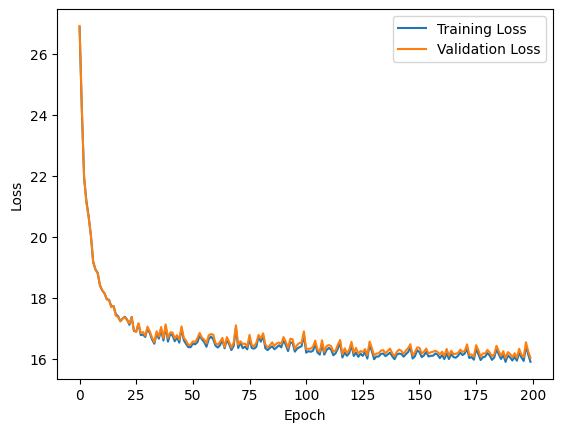

Average Reconstruction Error (Validation Set): 0.009563161771267783


In [2]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from nn import preprocess

# load the digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# normalize the data
X /= 16

# split the data into training and validation sets
X_train, X_val, y_train, y_val = preprocess.train_test_split_nn(X, y, test_size=0.2, random_state=42)

# generate 64x16x64 autoencoder architecture
nn_arch = [
    {"input_dim": 64, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 64, "activation": "sigmoid"}
]

# hyperparameter selection
lr = 0.1
seed = 42
batch_size = 64
epochs = 200
loss_function = "binary_cross_entropy"

# create NeuralNetwork instance
nn = NeuralNetwork(nn_arch, lr, seed, batch_size, epochs, loss_function)

# train the autoencoder
train_loss, val_loss = nn.fit(X_train, X_train, X_val, X_val)

# Plot training and validation loss by epoch
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# quantify average reconstruction error over the validation set
y_val_pred = nn.predict(X_val)
reconstruction_error = np.mean((y_val_pred - X_val) ** 2)
print("Average Reconstruction Error (Validation Set):", reconstruction_error)

In [3]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# load the digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# normalize the data
X /= 16

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# generate 64x16x64 autoencoder architecture
nn_arch = [
    {"input_dim": 64, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 64, "activation": "sigmoid"}
]

# hyperparameter ranges
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
epochs = [50, 100, 200]
loss_functions = ["mean_squared_error", "binary_cross_entropy"]
n_search_iter = 20

best_reconstruction_error = float('inf')
best_model = None

for _ in range(n_search_iter):
    # select hyperparameters
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    epoch = random.choice(epochs)
    loss_function = random.choice(loss_functions)

    # create a NeuralNetwork instance
    nn = NeuralNetwork(nn_arch, lr, seed, batch_size, epoch, loss_function)

    # train the autoencoder
    train_loss, val_loss = nn.fit(X_train, X_train, X_val, X_val)

    # calculate average reconstruction error
    y_val_pred = nn.predict(X_val)
    reconstruction_error = np.mean((y_val_pred - X_val) ** 2)

    # update best model and reconstruction error
    if reconstruction_error < best_reconstruction_error:
        best_reconstruction_error = reconstruction_error
        best_model = nn

    params = {
        'learning_rate': lr,
        'batch_size': batch_size,
        'epochs': epoch,
        'loss_function': loss_function
    }
    print(f"Parameters: {params}, Reconstruction Error: {reconstruction_error}")

print(f"Best Model Parameters: {best_model.get_hyperparameters()}, Reconstruction Error: {best_reconstruction_error}")

Parameters: {'learning_rate': 0.1, 'batch_size': 32, 'epochs': 50, 'loss_function': 'binary_cross_entropy'}, Reconstruction Error: 0.010465053753884616
Parameters: {'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'loss_function': 'mean_squared_error'}, Reconstruction Error: 0.1447688756290948
Parameters: {'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'loss_function': 'mean_squared_error'}, Reconstruction Error: 0.1447688756290948
Parameters: {'learning_rate': 0.1, 'batch_size': 16, 'epochs': 100, 'loss_function': 'binary_cross_entropy'}, Reconstruction Error: 0.009628763689282603
Parameters: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'loss_function': 'mean_squared_error'}, Reconstruction Error: 0.07030844211083331
Parameters: {'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'loss_function': 'mean_squared_error'}, Reconstruction Error: 0.0876133455249201
Parameters: {'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'loss_function': 'binary_c

Explanation for hyperparameter choices: The architecture of this autoencoder is 64x16x64. The output and input dimensions are 64, which is appropriate for the data in the digits dataset. The hidden layer has 16 neurons, which is able to learn a compressed representation of the input data. 

This implementation trains over 200 epochs, which is appropriate for learning patterns in this dataset without being excessively computationally demanding. In addition, a batch size of 64 is appropriate for mini-batch gradient descent implemented here, allowing for the network to learn patterns in the data quickly and converging as well. This is also reflected in the learning rate of 0.01, which is reasonable and avoids getting stuck in local minima. These were optimized using random searching which is able to optimize the hyperparameters by scanning through different combinations of learning rate, batch size, and epochs. In my implementation of the random search, the optimized model parameters are as follows:

Best Model Parameters: {'architecture': [{'input_dim': 64, 'output_dim': 16, 'activation': 'relu'}, {'input_dim': 16, 'output_dim': 64, 'activation': 'sigmoid'}], 'learning_rate': 0.1, 'seed': 42, 'batch_size': 64, 'epochs': 200, 'loss_function': 'binary_cross_entropy'}, Reconstruction Error: 0.009091564079858467